Let's load the packages and data that are necessary for the exercises.

In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
"""
# Nearby Spiral Globular Cluster Systems I: Luminosity Functions;
# Nantais J.B., Huchra J.P., Barmby P., Olsen K.A.G., Jarrett T.H.,
# Astronomical Journal 131, 1416-1425 (2006)
"""

absolute_MWG = np.loadtxt("GC_MWG_absolute.dat")
apparent_M31 = np.loadtxt("GC_M31_apparent.dat")

plt.figure()
plt.subplot(121)
plt.title("Milky Way")
plt.hist(absolute_MWG, bins=20)
plt.xlabel("K-band absolute magnitude")

plt.subplot(122)
plt.title("M31")
plt.hist(apparent_M31, bins=20)
plt.xlabel("K-band apparent magnitude")
plt.show()

<Figure size 640x480 with 2 Axes>

## Exercise 1: looking at M31 globular clusters
#### (a) Is the M31 data normally distributed? Use two different parametric tests from `scipy`.

In [5]:
_, pvalue = st.shapiro(apparent_M31)
print("p-value: {:.3g}".format(pvalue))

p-value: 0.00102


In [6]:
_, pvalue = st.normaltest(apparent_M31)
print("p-value: {:.3g}".format(pvalue))

p-value: 0.00414


#### (b) Test the normality of the M31 data using the Kolmogorov-Smirnov test and confirm that the produced $p$-value is quite large. What is the source of this going on in the case? Are there non-parametric tests that can bypass this complication?

In [9]:
# perform the K-S test using the Gaussian with mean and scale equal to the sample mean and standard deviation
mean = np.mean(apparent_M31)
std = np.std(apparent_M31)
normal_approximation = st.norm(loc=mean, scale=std)
_, pvalue = st.kstest(apparent_M31, normal_approximation.cdf)
print("p-value: {:.3g}".format(pvalue))

p-value: 0.108


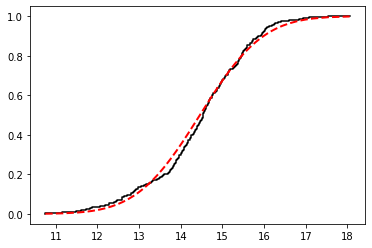

In [12]:
# Why does the K-S test gives such a high p-value? Let's look at the CDF.
plt.figure()
x_empirical = np.sort(apparent_M31)
y_empirical = np.arange(len(apparent_M31)) / (len(apparent_M31) - 1.0)

plt.step(x_empirical, y_empirical, "k-")
plt.plot(x_empirical, normal_approximation.cdf(x_empirical), "r--", linewidth=2)
plt.show()

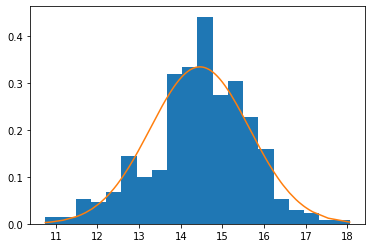

In [14]:
# Let's look at the empirical PDF and the normal approximation superposed...
plt.figure()
plt.hist(apparent_M31, bins=20, density=True)
plt.plot(x_empirical, normal_approximation.pdf(x_empirical))
plt.show()

In [23]:
# The difference of the empirical and approximate distribution is significant in the tails
# K-S is not very sensitive at the tails... Let's use the Anderson-Darling test

statistic, critical_values, significance_levels = st.anderson(apparent_M31)
print("Statistic: {:.4g}".format(statistic))
for critical_value, significance_level in zip(critical_values, significance_levels):
    outcome = "OK" if statistic < critical_value else "FAIL"
    print("At {:4.1f} level, the critical value is {:4.2g}: {}".format(significance_level, critical_value, outcome))

Statistic: 1.794
At 15.0 level, the critical value is 0.57: FAIL
At 10.0 level, the critical value is 0.65: FAIL
At  5.0 level, the critical value is 0.78: FAIL
At  2.5 level, the critical value is 0.91: FAIL
At  1.0 level, the critical value is  1.1: FAIL


#### (b) Whare are the variances of M31 and Milky Way data? Are the significantly different? Use at least two different methods.

In [33]:
print("MWG variance = {:.4f}".format(np.var(absolute_MWG)))
print("M31 variance = {:.4f}".format(np.var(apparent_M31)))

print()
print("Test                     p-value")
print("--------------------------------")
_, pvalue = st.levene(absolute_MWG, apparent_M31)
print("Levene test              {:.2g}".format(pvalue))

_, pvalue = st.bartlett(absolute_MWG, apparent_M31)
print("Bertlett's test          {:.2g}".format(pvalue))

_, pvalue = st.fligner(absolute_MWG, apparent_M31)
print("Fligner-Killeen test     {:.2g}".format(pvalue))

MWG variance = 3.2127
M31 variance = 1.4235

Test                     p-value
--------------------------------
Levene test              3.8e-06
Bertlett's test          3.5e-07
Fligner-Killeen test     1.4e-05


## Exercise 2: the distance of M31
#### (a) Assuming that the Milky Way and M31 globular clusters are complete and described by the same luminosity function, what is the distance of M31?

Remember that the distance modulus $\mu$, the absolute $M$ and apparent magnitude $m$ are connected through the formula:

$$ \mu = m - M $$

The metric distance $d$ (in Mpc) can be computed from the distance modulus using

$$ d = 10^{\mu / 5 - 5} $$

In [36]:
mwg_mean, mwg_sem = np.mean(absolute_MWG), st.sem(absolute_MWG)
m31_mean, m31_sem = np.mean(apparent_M31), st.sem(apparent_M31)
print("Milky way mean absolute magnitude: {:.2f} +/- {:.2f}".format(mwg_mean, mwg_sem))
print("Andromeda mean apparent magnitude: {:.2f} +/- {:.2f}".format(m31_mean, m31_sem))

def to_metric(distance_modulus):
    """Convert a distance modulus to metric distance in Mpc."""
    return 10.0 ** (distance_modulus / 5.0 - 5)

modulus = m31_mean - mwg_mean
distance = to_metric(modulus)
print("Distance modulus = {:.3f}".format(modulus))
print("Distance = {:.3g} Mpc".format(distance))

Milky way mean absolute magnitude: -10.32 +/- 0.20
Andromeda mean apparent magnitude: 14.46 +/- 0.06
Distance modulus = 24.781
Distance = 0.904 Mpc


#### (b) what is the uncertainty of that estimate?

In [47]:
# Error propagation theory: the standard deviation is the quadratic sum of the standard errors of the mean values.
modulus_error = (mwg_sem ** 2.0 + m31_sem ** 2.0) ** 0.5
print("Distance moudlus = {:.3f} +/- {:.3f}".format(modulus, modulus_error))

# converting to metric distance is not Gaussion anymore, therefore the +/- must be subtituted with a CI
distance = to_metric(modulus)
lower68 = to_metric(modulus - modulus_error)
upper68 = to_metric(modulus + modulus_error)
print("Distance = {:.3f} Mpc   |    68% CI = ({:.3f}, {:.3f}) Mpc".
      format(distance, lower68, upper68))

Distance moudlus = 24.781 +/- 0.210
Distance = 0.904 Mpc   |    68% CI = (0.821, 0.996) Mpc


#### (c) Is the computed distance consistent with the Cepheid estimate for the distance modulus: $24.44 \pm 0.10\ \rm mag$?

Cepheid distance modulus = 24.44 +/- 0.10
Cepheid distance = 0.773 Mpc    |     68% CI: (0.738, 0.809) Mpc


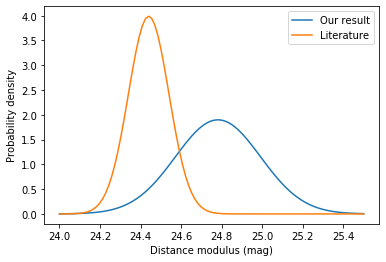

Z score: 1.47
p-value = 0.142
The two estimates are consistent.


In [67]:
cep_modulus = 24.44
cep_modulus_error = 0.1

print("Cepheid distance modulus = {:.2f} +/- {:.2f}".format(cep_modulus, cep_modulus_error))
cep_distance = to_metric(cep_modulus)
cep_lower68 = to_metric(cep_modulus - cep_modulus_error)
cep_upper68 = to_metric(cep_modulus + cep_modulus_error)
print("Cepheid distance = {:.3f} Mpc    |     68% CI: ({:.3f}, {:.3f}) Mpc".
      format(cep_distance, cep_lower68, cep_upper68))

# plot the two estimate's probability density
x = np.linspace(24, 25.5, 100)
y_result = st.norm.pdf(x, loc=modulus, scale=modulus_error)
y_theory = st.norm.pdf(x, loc=cep_modulus, scale=cep_modulus_error)
plt.figure()
plt.plot(x, y_result, label="Our result")
plt.plot(x, y_theory, label="Literature")
plt.legend(loc="upper right")
plt.xlabel("Distance modulus (mag)")
plt.ylabel("Probability density")
plt.show()

# HYPOTHESIS TESTING

# we may consider that the two estimates are consistent by testing whether their difference is consistent with zero

# we decide a significance level 5%
a = 0.05

# take the difference and its error (using propagation theory)
difference = (modulus - cep_modulus)
difference_error = (modulus_error ** 2.0 + cep_modulus_error ** 2.0) ** 0.5

# assuming normal distribution for the sample mean and the Cepheid estimate...
# their difference will also be normally distributed and we can use the Z-score to get a p-value
Z_score = difference / difference_error
print("Z score: {:.3g}".format(Z_score))
p_value = 2 * st.norm.cdf(-abs(Z_score))
print("p-value = {:.3f}".format(p_value))
if p_value < a:
    print("The two estimates are not consistent.")
else:
    print("The two estimates are consistent.")

#### (d) From the distance estimate, calculate the absolute magnitudes of M31 GCs. Check if they follow the same distribution as the absute magnitude of Milky Way GCs. Use at least two methods of two-sample tests.

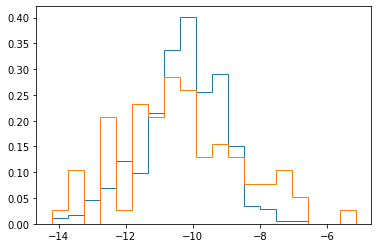

K-S 2-sample test
  Statistic:  0.135
  p-value  :  0.163
Wilcoxon rank-sum
  Statistic:  0.625
  p-value  :  0.532


In [73]:
absolute_M31 = apparent_M31 - modulus

# Looking at the distributions
x_min = min(min(absolute_M31), min(absolute_MWG))
x_max = max(max(absolute_M31), max(absolute_MWG))
bins = np.linspace(x_min, x_max, 20)
plt.hist(absolute_M31, bins=bins, density=True, histtype="step")
plt.hist(absolute_MWG, bins=bins, density=True, histtype="step")
plt.show()

print("K-S 2-sample test")
statistic, pvalue = st.ks_2samp(absolute_M31, absolute_MWG)
print("  Statistic:  {:.3g}".format(statistic))
print("  p-value  :  {:.3g}".format(pvalue))

print("Wilcoxon rank-sum")
statistic, pvalue = st.ranksums(absolute_M31, absolute_MWG)
print("  Statistic:  {:.3g}".format(statistic))
print("  p-value  :  {:.3g}".format(pvalue))

## Extra exercise 1: Normal approximation of Poisson distribution

It is known that the normal distribution is a good approximation of Poisson distribution when the parameter $\lambda$ is large.

#### (a) Can you quantify this claim using sampling and hypothesis testing? Choose a sample size $N$ and some $\lambda$ values.

#### (b) Do the results depend on the sample size?

#### (c) Do the results depend on the method? Use two tests at least.

For l=0.5
  SW: p-value = 5.9e-39
  KS: p-value = 3.95e-122
For l=3
  SW: p-value = 3.25e-18
  KS: p-value = 1.35e-18
For l=10
  SW: p-value = 2.7e-10
  KS: p-value = 2.55e-08
For l=30
  SW: p-value = 5.5e-06
  KS: p-value = 1.58e-05


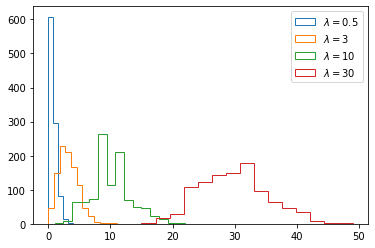

In [43]:
plt.figure()
sample_size = 1000
poisson_means_to_test = [0.5, 3, 10, 30]
for poisson_mean in poisson_means_to_test:
    sample = st.poisson.rvs(poisson_mean, size=sample_size)
    statistic, pvalue = st.shapiro(sample)
    print("For l={:.3g}".format(poisson_mean))
    print("  SW: p-value = {:.3g}".format(pvalue))
    
    norm_cdf = st.norm(loc=poisson_mean, scale=poisson_mean ** 0.5).cdf
    statistic, pvalue = st.kstest(sample, norm_cdf)
    print("  KS: p-value = {:.3g}".format(pvalue))
    
    nbins = min(15, max(sample) - min(sample) + 1)
    plt.hist(sample, bins=nbins, label=r"$\lambda = {:.2g}$".format(poisson_mean), histtype="step")
plt.legend()
plt.show()